# Packages

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
#import missingno as msno
import numpy as np
import pandas as pd
#import seaborn as sns
#from yellowbrick.regressor import ResidualsPlot
#from branca.colormap import linear
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import data

In [2]:
HOME_DIR = Path.cwd()
DATA_DIR = Path(HOME_DIR)

In [ ]:
# file_path = '/content/drive/My Drive/Yield_TA_data_1.csv'

# Yield_TI_data_1 = pd.read_csv(file_path)

In [3]:
Yield_TI_data_1 = pd.read_csv("E:\SAMS\datasets\Yield_TA_data_1.csv", sep=",")

In [4]:
Yield_TI_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483641 entries, 0 to 483640
Columns: 260 entries, Unnamed: 0 to mean_PRECTOTCORR
dtypes: float64(259), int64(1)
memory usage: 959.4 MB


# select the crops to be studied

In [60]:
#choose the data for RICE
Vars = ["rice_a", "whea_a","maiz_a","pmil_a","mill_a","sorg_a","pota_a","swpo_a"]

def CropSelect(crop, var, data):
    columns_to_drop = np.array(var)
    if crop in columns_to_drop:
        columns_to_drop = np.delete(columns_to_drop, np.where(columns_to_drop == crop))
    data = data.drop(columns_to_drop, axis=1)
    return data
spec_select = "pota_a"
data_rice = CropSelect(spec_select, Vars,Yield_TI_data_1)
data_rice = data_rice[data_rice[spec_select]>0]

# Modeling

In [6]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, ShuffleSplit, KFold

In [61]:
data_model = data_rice.loc[data_rice[spec_select].notnull()]

data_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 284748 entries, 0 to 483640
Columns: 253 entries, Unnamed: 0 to mean_PRECTOTCORR
dtypes: float64(252), int64(1)
memory usage: 551.8 MB


In [62]:
X = data_model.drop([spec_select], axis=1)
y = data_model.loc[:, spec_select]

In [9]:
y.head()

881     4032.1
953     4032.1
954     1825.9
1022    4032.1
1776    4032.1
Name: whea_a, dtype: float64

Split the database into training data and test data

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Standardize features

In [64]:
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

## Decision tree model

In [20]:
from sklearn.tree import DecisionTreeRegressor

Search for the right depth with cross validation

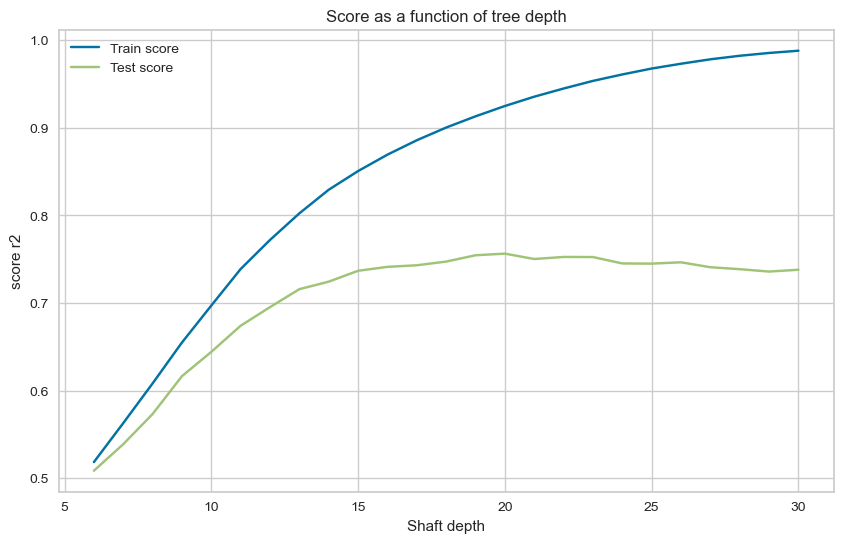

In [ ]:
train_errors = []
test_errors = []
kf = KFold(n_splits=5, random_state=42, shuffle=True)
scaler = StandardScaler()
for depth in range(6, 31):
    dtree_model_kf = DecisionTreeRegressor(max_depth=depth)

    r2_scores_test = []
    r2_scores_train = []

    for train_andex, test_andex in kf.split(X):

        X_train_kf, X_test_kf = X.iloc[train_andex], X.iloc[test_andex]
        y_train_kf, y_test_kf = y.iloc[train_andex], y.iloc[test_andex]

        scaler.fit(X_train_kf)
        X_train_kf_std = scaler.transform(X_train_kf)
        X_test_kf_std = scaler.transform(X_test_kf)

        dtree_model_kf.fit(X_train_kf_std, y_train_kf)
        y_test_pred = dtree_model_kf.predict(X_test_kf_std)
        y_train_pred = dtree_model_kf.predict(X_train_kf_std)

        r2_test =  r2_score(y_test_kf, y_test_pred)
        r2_train = r2_score(y_train_kf, y_train_pred)
        r2_scores_test.append(r2_test)
        r2_scores_train.append(r2_train)

    mean_r2_test = np.mean(r2_scores_test)
    mean_r2_train = np.mean(r2_scores_train)
    test_errors.append(mean_r2_test)
    train_errors.append(mean_r2_train)

plt.figure(figsize=(10, 6))
plt.plot(range(6, 31), train_errors, label="Train score")
plt.plot(range(6, 31), test_errors, label="Test score")
plt.xlabel("Shaft depth")
plt.ylabel("score r2")
plt.title("Score as a function of tree depth")
plt.legend()
plt.grid(True)
plt.show()

The graph above shows the model's score as a function of depth. Here we see that the model overlearns very quickly (over 10 already!).
We will limit ourselves to a depth of 9.

In [21]:
train_max_error = []
test_max_error = []
train_mean_absolute_error = []
test_mean_absolute_error = []
train_mean_absolute_percentage_error = []
test_mean_absolute_percentage_error = []
train_mean_squared_error = []
test_mean_squared_error = []
train_mean_squared_relative_error = []
test_mean_squared_relative_error = []
r2_scores_test = []
r2_scores_train = []

kf = KFold(n_splits=5, random_state=42, shuffle=True)
scaler = StandardScaler()
dtree_model_kf = DecisionTreeRegressor(max_depth=9)

for train_andex, test_andex in kf.split(X):

    X_train_kf, X_test_kf = X.iloc[train_andex], X.iloc[test_andex]
    y_train_kf, y_test_kf = y.iloc[train_andex], y.iloc[test_andex]

    scaler.fit(X_train_kf)
    scaler.fit(X_test_kf)
    X_train_kf_std = scaler.transform(X_train_kf)
    X_test_kf_std = scaler.transform(X_test_kf)

    dtree_model_kf.fit(X_train_kf_std, y_train_kf)
    y_test_pred = dtree_model_kf.predict(X_test_kf_std)
    y_train_pred = dtree_model_kf.predict(X_train_kf_std)

    me_test = max_error(y_test_kf, y_test_pred)
    me_train = max_error(y_train_kf, y_train_pred)
    mae_test = mean_absolute_error(y_test_kf, y_test_pred)
    mae_train = mean_absolute_error(y_train_kf, y_train_pred)
    mape_test = mean_absolute_percentage_error(y_test_kf, y_test_pred)
    mape_train = mean_absolute_percentage_error(y_train_kf, y_train_pred)
    mse_test = mean_squared_error(y_test_kf, y_test_pred)
    mse_train = mean_squared_error(y_train_kf, y_train_pred)
    rse_train = 1- r2_score(y_train_kf, y_train_pred)
    rse_test = 1- r2_score(y_test_kf, y_test_pred)
    r2_test =  r2_score(y_test_kf, y_test_pred)
    r2_train = r2_score(y_train_kf, y_train_pred)

    train_max_error.append(me_train)
    test_max_error.append(me_test)
    train_mean_absolute_error.append(mae_train)
    test_mean_absolute_error.append(mae_test)
    train_mean_absolute_percentage_error.append(mape_train)
    test_mean_absolute_percentage_error.append(mape_test)
    train_mean_squared_error.append(mse_train)
    test_mean_squared_error.append(mse_test)
    train_mean_squared_relative_error.append(rse_train)
    test_mean_squared_relative_error.append(rse_test)
    r2_scores_test.append(r2_test)
    r2_scores_train.append(r2_train)

Errors

In [22]:
print("########## Max error ############### :")
print(f"max_error test :  {np.mean(test_max_error):.2f}")
print(f"max_error train : {np.mean(train_max_error)}")
print("########## mean absolute error ############### :")
print(f"mean_absolute_error test :  {np.mean(train_max_error):.2f}")
print(f"mean_absolute_error train : {np.mean(test_mean_absolute_error):.2f}")
print("########## mean absolute percentage error ############### :")
print(f"mean_absolute_percentage_error test :  {np.mean(test_mean_absolute_percentage_error):.2f}")
print(f"mean_absolute_percentage_error train : {np.mean(train_mean_absolute_percentage_error):.2f}")
print("########## mean squared error ############### :")
print(f"mean_squared_error test :  {np.mean(test_mean_squared_error):.2f}")
print(f"mean_squared_error train : {np.mean(train_mean_squared_error):.2f}")
print("########## relative squared error ############### :")
print(f"mean_squared_relative_error test :  {np.mean(test_mean_squared_relative_error):.2f}")
print(f"mean_squared_relative_error train : {np.mean(train_mean_squared_relative_error):.2f}")

########## Max error ############### :
max_error test :  13909.19
max_error train : 7874.471075869835
########## mean absolute error ############### :
mean_absolute_error test :  7874.47
mean_absolute_error train : 359.14
########## mean absolute percentage error ############### :
mean_absolute_percentage_error test :  1.53
mean_absolute_percentage_error train : 1.47
########## mean squared error ############### :
mean_squared_error test :  323753.69
mean_squared_error train : 287996.58
########## relative squared error ############### :
mean_squared_relative_error test :  0.16
mean_squared_relative_error train : 0.13


Score

In [23]:
print(f"score test :  {np.mean(r2_scores_test)}")
print(f"score train : {np.mean(r2_scores_train)}")

score test :  0.8363043320479238
score train : 0.8736352820733663


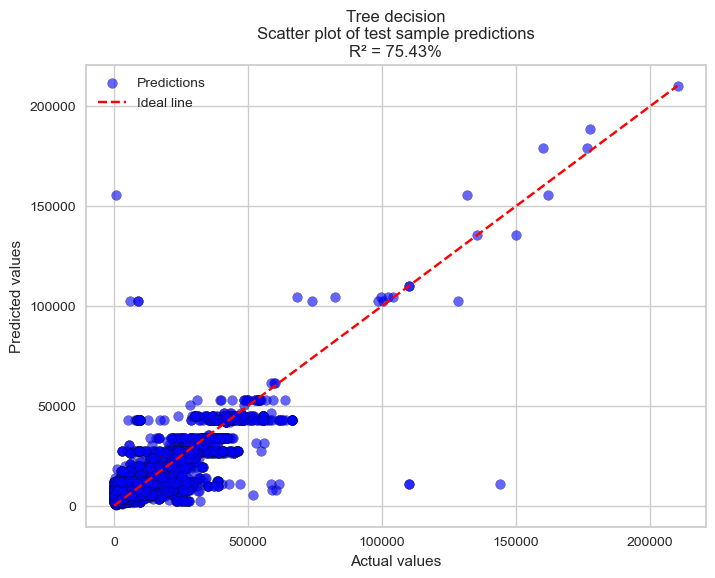

In [ ]:
y_test_pred_dtree = dtree_model_kf.predict(X_test_std)
r2_RF = np.mean(r2_scores_test)*100

# Tracé du nuage de points
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_dtree, alpha=0.6, color='blue', edgecolors='k', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal line')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title(f"Tree decision\nScatter plot of test sample predictions\nR² = {r2_RF:.2f}%")
plt.legend()
plt.grid(True)
plt.show()

## XG BOOST

In [ ]:
#pip install xgboost


     -------------------------------------- 124.9/124.9 MB 4.4 MB/s eta 0:00:00


In [12]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

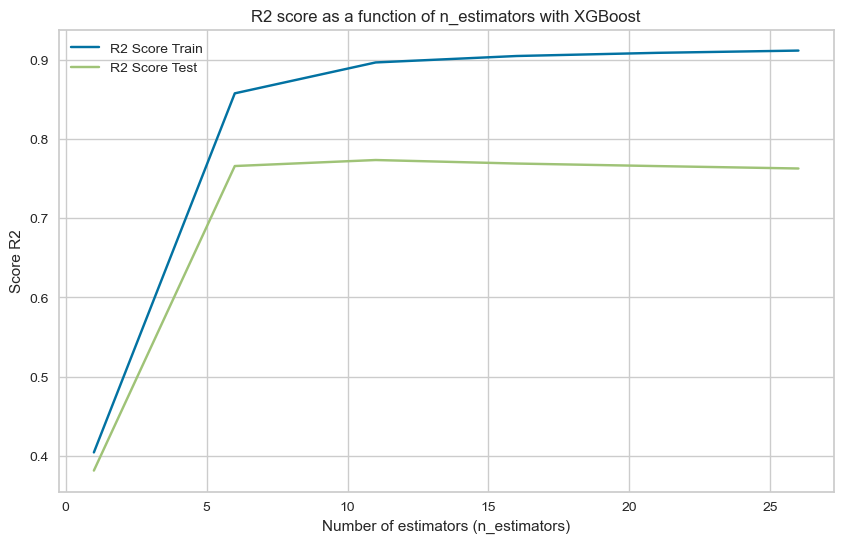

In [ ]:
n_estimators_range = np.arange(1, 31, 5)
train_scores = []
test_scores = []

for n in n_estimators_range:
    model = xgb.XGBRegressor(n_estimators=n, random_state=42, max_depth=16)
    model.fit(X_train_std, y_train)

    y_train_pred = model.predict(X_train_std)
    y_test_pred = model.predict(X_test_std)

    train_scores.append(r2_score(y_train, y_train_pred))
    test_scores.append(r2_score(y_test, y_test_pred))

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_scores, label="R2 Score Train")
plt.plot(n_estimators_range, test_scores, label="R2 Score Test")
plt.xlabel("Number of estimators (n_estimators)")
plt.ylabel("Score R2")
plt.title("R2 score as a function of n_estimators with XGBoost")
plt.legend()
plt.grid(True)
plt.show()

In [42]:
train_max_error = []
test_max_error = []
train_mean_absolute_error = []
test_mean_absolute_error = []
train_mean_absolute_percentage_error = []
test_mean_absolute_percentage_error = []
train_mean_squared_error = []
test_mean_squared_error = []
train_mean_squared_relative_error = []
test_mean_squared_relative_error = []
r2_scores_test = []
r2_scores_train = []

kf = KFold(n_splits=5, random_state=42, shuffle=True)
scaler = StandardScaler()
xgb_model = xgb.XGBRegressor(n_estimators=6, random_state=42, max_depth=16)

for train_andex, test_andex in kf.split(X):

    X_train_kf, X_test_kf = X.iloc[train_andex], X.iloc[test_andex]
    y_train_kf, y_test_kf = y.iloc[train_andex], y.iloc[test_andex]

    scaler.fit(X_train_kf)
    scaler.fit(X_test_kf)
    X_train_kf_std = scaler.transform(X_train_kf)
    X_test_kf_std = scaler.transform(X_test_kf)

    xgb_model.fit(X_train_kf_std, y_train_kf)
    y_test_pred = xgb_model.predict(X_test_kf_std)
    y_train_pred = xgb_model.predict(X_train_kf_std)

    me_test = max_error(y_test_kf, y_test_pred)
    me_train = max_error(y_train_kf, y_train_pred)
    mae_test = mean_absolute_error(y_test_kf, y_test_pred)
    mae_train = mean_absolute_error(y_train_kf, y_train_pred)
    mape_test = mean_absolute_percentage_error(y_test_kf, y_test_pred)
    mape_train = mean_absolute_percentage_error(y_train_kf, y_train_pred)
    mse_test = mean_squared_error(y_test_kf, y_test_pred)
    mse_train = mean_squared_error(y_train_kf, y_train_pred)
    rse_train = 1- r2_score(y_train_kf, y_train_pred)
    rse_test = 1- r2_score(y_test_kf, y_test_pred)
    r2_test =  r2_score(y_test_kf, y_test_pred)
    r2_train = r2_score(y_train_kf, y_train_pred)

    train_max_error.append(me_train)
    test_max_error.append(me_test)
    train_mean_absolute_error.append(mae_train)
    test_mean_absolute_error.append(mae_test)
    train_mean_absolute_percentage_error.append(mape_train)
    test_mean_absolute_percentage_error.append(mape_test)
    train_mean_squared_error.append(mse_train)
    test_mean_squared_error.append(mse_test)
    train_mean_squared_relative_error.append(rse_train)
    test_mean_squared_relative_error.append(rse_test)
    r2_scores_test.append(r2_test)
    r2_scores_train.append(r2_train)

In [58]:
xgb_model = xgb.XGBRegressor(n_estimators=6, random_state=42, max_depth=16)
xgb_model.fit(X_train_std, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=16, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=6, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [59]:
xgb_model.save_model("xgb_model_maiz.json")

In [40]:
y_test_pred = xgb_model.predict(X_test_std)
y_train_pred = xgb_model.predict(X_train_std)

In [41]:
print(f"score test :  {r2_score(y_test_pred, y_test)}")
print(f"score train : {r2_score(y_train_pred, y_train)}")

score test :  0.6608321292266954
score train : 0.7581760156872334


Errors

In [22]:
print("########## Max error ############### :")
print(f"max_error test :  {np.mean(test_max_error):.2f}")
print(f"max_error train : {np.mean(train_max_error):.2f}")
print("########## mean absolute error ############### :")
print(f"mean_absolute_error test :  {np.mean(train_max_error):.2f}")
print(f"mean_absolute_error train : {np.mean(test_mean_absolute_error):.2f}")
print("########## mean absolute percentage error ############### :")
print(f"mean_absolute_percentage_error test :  {np.mean(test_mean_absolute_percentage_error):.2f}")
print(f"mean_absolute_percentage_error train : {np.mean(train_mean_absolute_percentage_error):.2f}")
print("########## mean squared error ############### :")
print(f"mean_squared_error test :  {np.mean(test_mean_squared_error):.2f}")
print(f"mean_squared_error train : {np.mean(train_mean_squared_error):.2f}")
print("########## relative squared error ############### :")
print(f"mean_squared_relative_error test :  {np.mean(test_mean_squared_relative_error):.2f}")
print(f"mean_squared_relative_error train : {np.mean(train_mean_squared_relative_error):.2f}")

########## Max error ############### :
max_error test :  106511.60
max_error train : 99730.75
########## mean absolute error ############### :
mean_absolute_error test :  99730.75
mean_absolute_error train : 1060.07
########## mean absolute percentage error ############### :
mean_absolute_percentage_error test :  1.72
mean_absolute_percentage_error train : 1.59
########## mean squared error ############### :
mean_squared_error test :  5056651.78
mean_squared_error train : 3806075.95
########## relative squared error ############### :
mean_squared_relative_error test :  0.23
mean_squared_relative_error train : 0.17


Scores

In [43]:
print(f"score test :  {np.mean(r2_scores_test)}")
print(f"score train : {np.mean(r2_scores_train)}")

score test :  0.8634833704018977
score train : 0.9118263194083877


Graphique

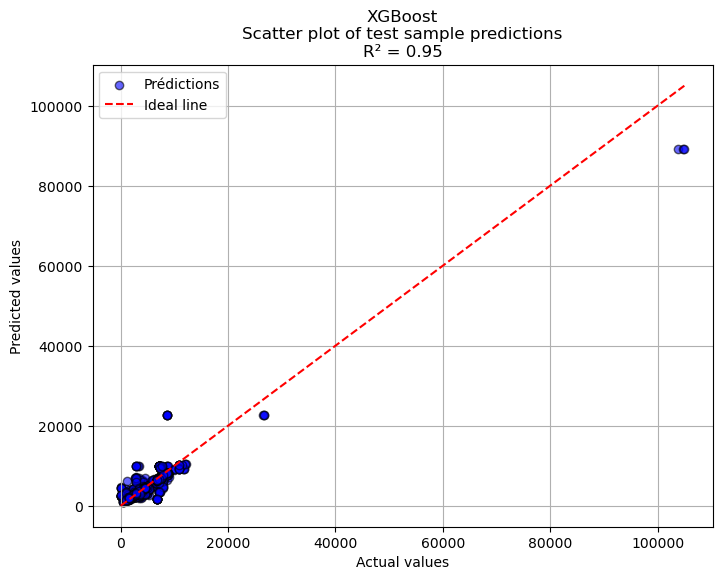

In [ ]:
r2_xgb = np.mean(r2_scores_test)
y_test_pred_xgb = xgb_model.predict(X_test_std)

# Tracé du nuage de points
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_xgb, alpha=0.6, color='blue', edgecolors='k', label='Prédictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal line')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title(f"XGBoost\nScatter plot of test sample predictions\nR² = {r2_xgb:.2f}")
plt.legend()
plt.grid(True)
plt.show()

## KNN Regressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

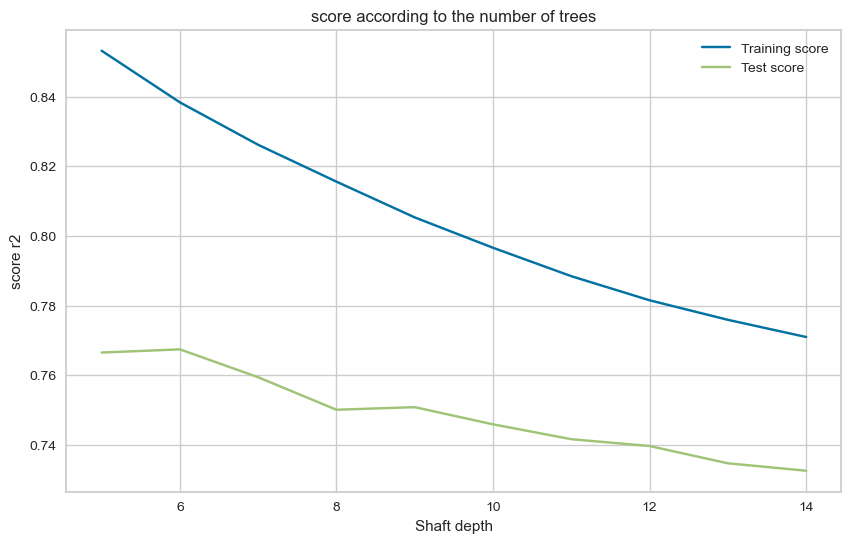

In [ ]:
train_errors = []
test_errors = []
kf = KFold(n_splits=5, random_state=42, shuffle=True)
scaler = StandardScaler()
for depth in range(5, 15):
    neigh = KNeighborsRegressor(n_neighbors=depth)

    rse_scores = []  # RSE
    r2_scores_test = []
    r2_scores_train = []

    for train_andex, test_andex in kf.split(X):

        X_train_kf, X_test_kf = X.iloc[train_andex], X.iloc[test_andex]
        y_train_kf, y_test_kf = y.iloc[train_andex], y.iloc[test_andex]

        scaler.fit(X_train_kf)
        X_train_kf_std = scaler.transform(X_train_kf)
        X_test_kf_std = scaler.transform(X_test_kf)

        neigh.fit(X_train_kf_std, y_train_kf)
        y_test_pred = neigh.predict(X_test_kf_std)
        y_train_pred = neigh.predict(X_train_kf_std)

        #rse = mean_squared_error(y_test_kf, y_test_pred)
        r2_test =  r2_score(y_test_kf, y_test_pred)
        r2_train = r2_score(y_train_kf, y_train_pred)
        #rse_scores.append(rse)
        r2_scores_test.append(r2_test)
        r2_scores_train.append(r2_train)

    #mean_rse = np.mean(rse_scores)
    mean_r2_test = np.mean(r2_scores_test)
    mean_r2_train = np.mean(r2_scores_train)
    test_errors.append(mean_r2_test)
    train_errors.append(mean_r2_train)

plt.figure(figsize=(10, 6))
plt.plot(range(5, 15), train_errors, label="Training score")
plt.plot(range(5, 15), test_errors, label="Test score")
plt.xlabel("Shaft depth")
plt.ylabel("score r2")
plt.title("score according to the number of trees")
plt.legend()
plt.grid(True)
plt.show()

Model

In [27]:
train_max_error = []
test_max_error = []
train_mean_absolute_error = []
test_mean_absolute_error = []
train_mean_absolute_percentage_error = []
test_mean_absolute_percentage_error = []
train_mean_squared_error = []
test_mean_squared_error = []
train_mean_squared_relative_error = []
test_mean_squared_relative_error = []
r2_scores_test = []
r2_scores_train = []

kf = KFold(n_splits=5, random_state=42, shuffle=True)
scaler = StandardScaler()
neigh = KNeighborsRegressor(n_neighbors=6)

for train_andex, test_andex in kf.split(X):

    X_train_kf, X_test_kf = X.iloc[train_andex], X.iloc[test_andex]
    y_train_kf, y_test_kf = y.iloc[train_andex], y.iloc[test_andex]

    scaler.fit(X_train_kf)
    scaler.fit(X_test_kf)
    X_train_kf_std = scaler.transform(X_train_kf)
    X_test_kf_std = scaler.transform(X_test_kf)

    neigh.fit(X_train_kf_std, y_train_kf)
    y_test_pred = neigh.predict(X_test_kf_std)
    y_train_pred = neigh.predict(X_train_kf_std)

    me_test = max_error(y_test_kf, y_test_pred)
    me_train = max_error(y_train_kf, y_train_pred)
    mae_test = mean_absolute_error(y_test_kf, y_test_pred)
    mae_train = mean_absolute_error(y_train_kf, y_train_pred)
    mape_test = mean_absolute_percentage_error(y_test_kf, y_test_pred)
    mape_train = mean_absolute_percentage_error(y_train_kf, y_train_pred)
    mse_test = mean_squared_error(y_test_kf, y_test_pred)
    mse_train = mean_squared_error(y_train_kf, y_train_pred)
    rse_train = 1- r2_score(y_train_kf, y_train_pred)
    rse_test = 1- r2_score(y_test_kf, y_test_pred)
    r2_test =  r2_score(y_test_kf, y_test_pred)
    r2_train = r2_score(y_train_kf, y_train_pred)

    train_max_error.append(me_train)
    test_max_error.append(me_test)
    train_mean_absolute_error.append(mae_train)
    test_mean_absolute_error.append(mae_test)
    train_mean_absolute_percentage_error.append(mape_train)
    test_mean_absolute_percentage_error.append(mape_test)
    train_mean_squared_error.append(mse_train)
    test_mean_squared_error.append(mse_test)
    train_mean_squared_relative_error.append(rse_train)
    test_mean_squared_relative_error.append(rse_test)
    r2_scores_test.append(r2_test)
    r2_scores_train.append(r2_train)

NameError: name 'KNeighborsRegressor' is not defined

Erros

In [ ]:
print("########## Max error ############### :")
print(f"max_error test :  {np.mean(test_max_error)}")
print(f"max_error train : {np.mean(train_max_error)}")
print("########## mean absolute error ############### :")
print(f"mean_absolute_error test :  {np.mean(train_max_error)}")
print(f"mean_absolute_error train : {np.mean(test_mean_absolute_error)}")
print("########## mean absolute percentage error ############### :")
print(f"mean_absolute_percentage_error test :  {np.mean(test_mean_absolute_percentage_error)}")
print(f"mean_absolute_percentage_error train : {np.mean(train_mean_absolute_percentage_error)}")
print("########## mean squared error ############### :")
print(f"mean_squared_error test :  {np.mean(test_mean_squared_error)}")
print(f"mean_squared_error train : {np.mean(train_mean_squared_error)}")
print("########## relative squared error ############### :")
print(f"mean_squared_relative_error test :  {np.mean(test_mean_squared_relative_error)}")
print(f"mean_squared_relative_error train : {np.mean(train_mean_squared_relative_error)}")

########## Max error ############### :
max_error test :  32225.35
max_error train : 36603.003333333334
########## mean absolute error ############### :
mean_absolute_error test :  36603.003333333334
mean_absolute_error train : 180.60040830671704
########## mean absolute percentage error ############### :
mean_absolute_percentage_error test :  0.9531076284234331
mean_absolute_percentage_error train : 0.7557800158606154
########## mean squared error ############### :
mean_squared_error test :  915883.8505386179
mean_squared_error train : 586613.4402327165
########## relative squared error ############### :
mean_squared_relative_error test :  0.11722072067660858
mean_squared_relative_error train : 0.04391044204272236


Score

In [ ]:
print(f"score test :  {np.mean(r2_scores_test)}")
print(f"score train : {np.mean(r2_scores_train)}")

score test :  0.8827792793233915
score train : 0.9560895579572776


## LIGHTGBM

In [33]:
pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB 330.3 kB/s eta 0:00:05
   - -------------------------------------- 0.0/1.4 MB 393.8 kB/s eta 0:00:04
   - -------------------------------------- 0.0/1.4 MB 393.8 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/1.4 MB 525.1 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/1.4 MB 454.0 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.4 MB 532.5 kB/s eta 0:00:03
   ---- ----------------------------------- 0.2/1.4 MB 553.5 kB/s eta 0:00:03
   ------ --------------------------------- 0.2/1.4 MB 599.0 kB/s eta 0:00:03
   ------ --------------------------------- 0.2/1.4 MB 577.6 kB/s eta 0:00:03
   ------- -------------------------------- 0.3/1.4 MB 681.0 kB/s eta 0:00:02
   --------- ------------------------------ 0.3/1.4 MB 698.2 kB/s eta 0:00:02
   ----------- ---------------------------- 0.4/1.4 MB 732.8 kB/s eta 0:0


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import lightgbm as lgb

In [ ]:
train_errors = []
test_errors = []
kf = KFold(n_splits=5, random_state=42, shuffle=True)
scaler = StandardScaler()
for n in range(15, 200):
    lgbm = lgb.LGBMRegressor(n_estimators=n, reg_lambda = 5, max_depth = 17)

    rse_scores = []  # RSE
    r2_scores_test = []
    r2_scores_train = []

    for train_andex, test_andex in kf.split(X):

        X_train_kf, X_test_kf = X.iloc[train_andex], X.iloc[test_andex]
        y_train_kf, y_test_kf = y.iloc[train_andex], y.iloc[test_andex]

        scaler.fit(X_train_kf)
        X_train_kf_std = scaler.transform(X_train_kf)
        X_test_kf_std = scaler.transform(X_test_kf)

        lgbm.fit(X_train_kf_std, y_train_kf)
        y_test_pred = lgbm.predict(X_test_kf_std)
        y_train_pred = lgbm.predict(X_train_kf_std)

        #rse = mean_squared_error(y_test_kf, y_test_pred)
        r2_test =  r2_score(y_test_kf, y_test_pred)
        r2_train = r2_score(y_train_kf, y_train_pred)
        #rse_scores.append(rse)
        r2_scores_test.append(r2_test)
        r2_scores_train.append(r2_train)

    #mean_rse = np.mean(rse_scores)
    mean_r2_test = np.mean(r2_scores_test)
    mean_r2_train = np.mean(r2_scores_train)
    test_errors.append(mean_r2_test)
    train_errors.append(mean_r2_train)

plt.figure(figsize=(10, 6))
plt.plot(range(15, 200), train_errors, label="Training score")
plt.plot(range(15, 200), test_errors, label="Test score")
plt.xlabel("Shaft n")
plt.ylabel("score r2")
plt.title("Number of boosted trees to fit")
plt.legend()
plt.grid(True)
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21042
[LightGBM] [Info] Number of data points in the train set: 10498, number of used features: 88
[LightGBM] [Info] Start training from score 4383.841546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21038
[LightGBM] [Info] Number of data points in the train set: 10498, number of used features: 88
[LightGBM] [Info] Start training from score 4346.362312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21015
[LightGBM] [Info] Number of data points in the train set: 10498, number of used features: 88
[LightGBM] [Info] 

KeyboardInterrupt: 

Model

In [35]:
train_max_error = []
test_max_error = []
train_mean_absolute_error = []
test_mean_absolute_error = []
train_mean_absolute_percentage_error = []
test_mean_absolute_percentage_error = []
train_mean_squared_error = []
test_mean_squared_error = []
train_mean_squared_relative_error = []
test_mean_squared_relative_error = []
r2_scores_test = []
r2_scores_train = []

kf = KFold(n_splits=5, random_state=42, shuffle=True)
scaler = StandardScaler()
lgbm = lgb.LGBMRegressor(n_estimators=175, max_depth = 17)

for train_andex, test_andex in kf.split(X):

    X_train_kf, X_test_kf = X.iloc[train_andex], X.iloc[test_andex]
    y_train_kf, y_test_kf = y.iloc[train_andex], y.iloc[test_andex]

    scaler.fit(X_train_kf)
    scaler.fit(X_test_kf)
    X_train_kf_std = scaler.transform(X_train_kf)
    X_test_kf_std = scaler.transform(X_test_kf)

    lgbm.fit(X_train_kf_std, y_train_kf)
    y_test_pred = lgbm.predict(X_test_kf_std)
    y_train_pred = lgbm.predict(X_train_kf_std)

    me_test = max_error(y_test_kf, y_test_pred)
    me_train = max_error(y_train_kf, y_train_pred)
    mae_test = mean_absolute_error(y_test_kf, y_test_pred)
    mae_train = mean_absolute_error(y_train_kf, y_train_pred)
    mape_test = mean_absolute_percentage_error(y_test_kf, y_test_pred)
    mape_train = mean_absolute_percentage_error(y_train_kf, y_train_pred)
    mse_test = mean_squared_error(y_test_kf, y_test_pred)
    mse_train = mean_squared_error(y_train_kf, y_train_pred)
    rse_train = 1- r2_score(y_train_kf, y_train_pred)
    rse_test = 1- r2_score(y_test_kf, y_test_pred)
    r2_test =  r2_score(y_test_kf, y_test_pred)
    r2_train = r2_score(y_train_kf, y_train_pred)

    train_max_error.append(me_train)
    test_max_error.append(me_test)
    train_mean_absolute_error.append(mae_train)
    test_mean_absolute_error.append(mae_test)
    train_mean_absolute_percentage_error.append(mape_train)
    test_mean_absolute_percentage_error.append(mape_test)
    train_mean_squared_error.append(mse_train)
    test_mean_squared_error.append(mse_test)
    train_mean_squared_relative_error.append(rse_train)
    test_mean_squared_relative_error.append(rse_test)
    r2_scores_test.append(r2_test)
    r2_scores_train.append(r2_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57081
[LightGBM] [Info] Number of data points in the train set: 227798, number of used features: 238
[LightGBM] [Info] Start training from score 21347.310356
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.264349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57078
[LightGBM] [Info] Number of data points in the train set: 227798, number of used features: 238
[LightGBM] [Info] Start training from score 21326.344195
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57041
[LightGBM] [Info] Number of data points i

In [65]:
lgbm = lgb.LGBMRegressor(n_estimators=175, max_depth = 17)
lgbm.fit(X_train_std, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.262963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57083
[LightGBM] [Info] Number of data points in the train set: 199323, number of used features: 238
[LightGBM] [Info] Start training from score 21353.236207


LGBMRegressor(max_depth=17, n_estimators=175)

In [66]:
booster = lgbm.booster_
booster.save_model("lgbm_pota.json")

In [17]:
y_test_pred = lgbm.predict(X_test_std)
y_train_pred = lgbm.predict(X_train_std)

In [18]:
print(f"score test :  {r2_score(y_test_pred, y_test)}")
print(f"score train : {r2_score(y_train_pred, y_train)}")

score test :  0.5472045722314367
score train : 0.9187329408445797


Errors

In [41]:
print("########## Max error ############### :")
print(f"max_error test :  {np.mean(test_max_error)}")
print(f"max_error train : {np.mean(train_max_error)}")
print("########## mean absolute error ############### :")
print(f"mean_absolute_error test :  {np.mean(train_max_error)}")
print(f"mean_absolute_error train : {np.mean(test_mean_absolute_error)}")
print("########## mean absolute percentage error ############### :")
print(f"mean_absolute_percentage_error test :  {np.mean(test_mean_absolute_percentage_error)}")
print(f"mean_absolute_percentage_error train : {np.mean(train_mean_absolute_percentage_error)}")
print("########## mean squared error ############### :")
print(f"mean_squared_error test :  {np.mean(test_mean_squared_error)}")
print(f"mean_squared_error train : {np.mean(train_mean_squared_error)}")
print("########## relative squared error ############### :")
print(f"mean_squared_relative_error test :  {np.mean(test_mean_squared_relative_error)}")
print(f"mean_squared_relative_error train : {np.mean(train_mean_squared_relative_error)}")

########## Max error ############### :
max_error test :  791654.4342822706
max_error train : 829590.6648458539
########## mean absolute error ############### :
mean_absolute_error test :  829590.6648458539
mean_absolute_error train : 1396.4219727890527
########## mean absolute percentage error ############### :
mean_absolute_percentage_error test :  1.7167222960938109
mean_absolute_percentage_error train : 1.6867954711447406
########## mean squared error ############### :
mean_squared_error test :  232956778.06945762
mean_squared_error train : 151267996.519926
########## relative squared error ############### :
mean_squared_relative_error test :  0.2550197440059964
mean_squared_relative_error train : 0.16327665523606705


Scores

In [36]:
print(f"score test :  {np.mean(r2_scores_test)}")
print(f"score train : {np.mean(r2_scores_train)}")

score test :  0.766335556954304
score train : 0.8169545865819507


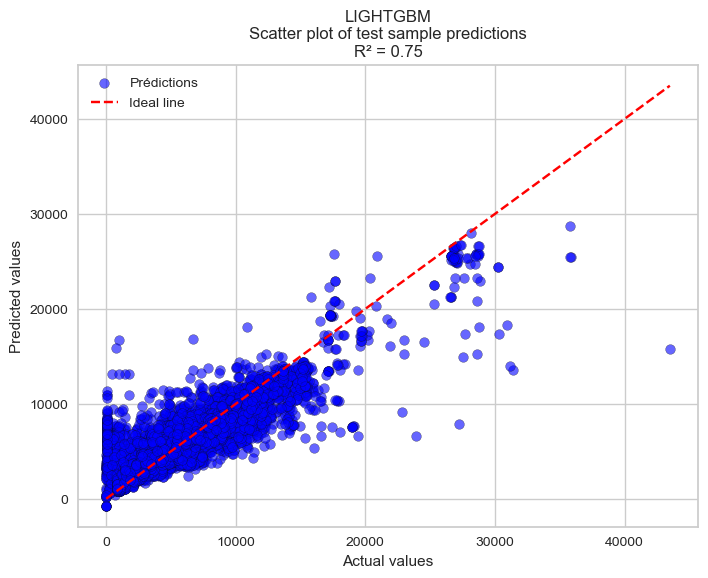

In [ ]:
r2_lgbm = np.mean(r2_scores_test)
y_test_pred_lgbm = lgbm.predict(X_test_std)

# Tracé du nuage de points
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_lgbm, alpha=0.6, color='blue', edgecolors='k', label='Prédictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal line')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title(f"LIGHTGBM\nScatter plot of test sample predictions\nR² = {r2_lgbm:.2f}")
plt.legend()
plt.grid(True)
plt.show()

## StackingRegressor

In [ ]:
from sklearn.ensemble import StackingRegressor

In [ ]:
estimators = [('xgb',xgb.XGBRegressor(n_estimators=45, learning_rate=0.1, max_depth=15)),
              ('KNN', KNeighborsRegressor(n_neighbors=6))]

Model

In [ ]:
final_estimator =lgb.LGBMRegressor(n_estimators=175,max_depth = 17)
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator)
reg.fit(X_train_std, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 9186, number of used features: 2
[LightGBM] [Info] Start training from score 4367.243050


StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=15,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=45, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('KNN', KNeighborsRegressor(n_neighbors=6))],
                  final_estimator=LGBMRegressor(max_depth=17, n_estimators=175))

In [ ]:
y_pred_test = reg.predict(X_test_std)
y_pred_train = reg.predict(X_train_std)
print('R2 score train : {:.2f}'.format(r2_score(y_test, y_pred_test)))
print('R2 score test : {:.2f}'.format(r2_score(y_train, y_pred_train)))

R2 score train : 0.35
R2 score test : 0.57


# Cross validation

In [ ]:
lgbm_scores_test = []
lgbm_scores_train = []
reg_scores_test = []
reg_scores_train = []
neigh_scores_test = []
neigh_scores_train = []
xgb_model_scores_test = []
xgb_model_scores_train = []

lgbm_rse_test = []
lgbm_rse_train = []
reg_rse_test = []
reg_rse_train = []
neigh_rse_test = []
neigh_rse_train = []
xgb_model_rse_test = []
xgb_model_rse_train = []

kf = KFold(n_splits=5, random_state=42, shuffle=True)
scaler = StandardScaler()

for train_andex, test_andex in kf.split(X):

    X_train_kf, X_test_kf = X.iloc[train_andex], X.iloc[test_andex]
    y_train_kf, y_test_kf = y.iloc[train_andex], y.iloc[test_andex]

    scaler.fit(X_train_kf)
    scaler.fit(X_test_kf)
    X_train_kf_std = scaler.transform(X_train_kf)
    X_test_kf_std = scaler.transform(X_test_kf)

    lgbm.fit(X_train_kf_std, y_train_kf)
    reg.fit(X_train_kf_std, y_train_kf)
    neigh.fit(X_train_kf_std, y_train_kf)
    xgb_model.fit(X_train_kf_std, y_train_kf)

    y_test_pred_lgbm = lgbm.predict(X_test_kf_std)
    y_train_pred_lgbm = lgbm.predict(X_train_kf_std)
    y_test_pred_reg = reg.predict(X_test_kf_std)
    y_train_pred_reg = reg.predict(X_train_kf_std)
    y_test_pred_neigh = neigh.predict(X_test_kf_std)
    y_train_pred_neigh = neigh.predict(X_train_kf_std)
    y_test_pred_xgb_model = xgb_model.predict(X_test_kf_std)
    y_train_pred_xgb_model = xgb_model.predict(X_train_kf_std)


    rse_train_xgb_model = 1- r2_score(y_train_kf, y_train_pred_xgb_model)
    rse_test_xgb_model = 1- r2_score(y_test_kf, y_test_pred_xgb_model)
    r2_test_xgb_model =  r2_score(y_test_kf, y_test_pred_xgb_model)
    r2_train_xgb_model = r2_score(y_train_kf, y_train_pred_xgb_model)

    rse_train_reg = 1- r2_score(y_train_kf, y_train_pred_reg)
    rse_test_reg = 1- r2_score(y_test_kf, y_test_pred_reg)
    r2_test_reg =  r2_score(y_test_kf, y_test_pred_reg)
    r2_train_reg = r2_score(y_train_kf, y_train_pred_reg)

    rse_train_neigh = 1- r2_score(y_train_kf, y_train_pred_neigh)
    rse_test_neigh = 1- r2_score(y_test_kf, y_test_pred_neigh)
    r2_test_neigh =  r2_score(y_test_kf, y_test_pred_neigh)
    r2_train_neigh = r2_score(y_train_kf, y_train_pred_neigh)

    rse_train_lgbm = 1- r2_score(y_train_kf, y_train_pred_lgbm)
    rse_test_lgbm = 1- r2_score(y_test_kf, y_test_pred_lgbm)
    r2_test_lgbm =  r2_score(y_test_kf, y_test_pred_lgbm)
    r2_train_lgbm = r2_score(y_train_kf, y_train_pred_lgbm)

    lgbm_scores_test.append(r2_test_lgbm)
    lgbm_scores_train.append(r2_train_lgbm)
    lgbm_rse_test.append(rse_test_lgbm)
    lgbm_rse_train.append(rse_train_lgbm)

    reg_rse_test.append(rse_test_reg)
    reg_rse_train.append(rse_train_reg)
    reg_scores_test.append(r2_test_reg)
    reg_scores_train.append(r2_train_reg)

    neigh_rse_test.append(rse_test_neigh)
    neigh_rse_train.append(rse_train_neigh)
    neigh_scores_test.append(r2_test_neigh)
    neigh_scores_train.append(r2_train_neigh)

    xgb_model_rse_test.append(rse_test_xgb_model)
    xgb_model_rse_train.append(rse_train_xgb_model)
    xgb_model_scores_test.append(r2_test_xgb_model)
    xgb_model_scores_train.append(r2_train_xgb_model)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 87
[LightGBM] [Info] Start training from score 5954.380588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 61166, number of used features: 2
[LightGBM] [Info] Start training from score 5954.380588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21974
[LightGBM] [Info] Number of data points in the tra

Results

In [ ]:
print("########## lightgbm MODEL ############### :")
print(f"rse test :  {np.mean(lgbm_rse_test)}")
print(f"rse train :  {np.mean(lgbm_rse_train)}")
print(f"score test :  {np.mean(lgbm_scores_test)}")
print(f"score train :  {np.mean(lgbm_scores_train)}")

print("########## KNN Regressor ############### :")
print(f"rse test :  {np.mean(neigh_rse_test)}")
print(f"rse train :  {np.mean(neigh_rse_train)}")
print(f"score test :  {np.mean(neigh_scores_test)}")
print(f"score train :  {np.mean(neigh_scores_train)}")

print("########## XGB BOOST MODEL ############### :")
print(f"rse test :  {np.mean(xgb_model_rse_test)}")
print(f"rse train :  {np.mean(xgb_model_rse_train)}")
print(f"score test :  {np.mean(xgb_model_scores_test)}")
print(f"score train :  {np.mean(xgb_model_scores_train)}")

print("########## StackingRegressor MODEL ############### :")
print(f"rse test :  {np.mean(reg_rse_test)}")
print(f"rse train :  {np.mean(reg_rse_train)}")
print(f"score test :  {np.mean(reg_scores_test)}")
print(f"score train :  {np.mean(reg_scores_train)}")

########## lightgbm MODEL ############### :
rse test :  0.24784562990804834
rse train :  0.20537031253762633
score test :  0.7521543700919515
score train :  0.7946296874623736
########## KNN Regressor ############### :
rse test :  0.23581361874464218
rse train :  0.16117827604657603
score test :  0.7641863812553578
score train :  0.838821723953424
########## XGB BOOST MODEL ############### :
rse test :  0.24931536905468601
rse train :  0.16446375110822806
score test :  0.750684630945314
score train :  0.835536248891772
########## StackingRegressor MODEL ############### :
rse test :  0.44761037605427106
rse train :  0.3932873767026275
score test :  0.5523896239457289
score train :  0.6067126232973725


## The best(s) model(s)

#### The bests models are XGB BOOST MODEL and KNN Regressor

##### KNN Model

In [ ]:
train_mean_squared_relative_error = []
test_mean_squared_relative_error = []
r2_scores_test = []
r2_scores_train = []

kf = KFold(n_splits=5, random_state=42, shuffle=True)
scaler = StandardScaler()
neigh = KNeighborsRegressor(n_neighbors=6)

for train_andex, test_andex in kf.split(X):

    X_train_kf, X_test_kf = X.iloc[train_andex], X.iloc[test_andex]
    y_train_kf, y_test_kf = y.iloc[train_andex], y.iloc[test_andex]

    scaler.fit(X_train_kf)
    scaler.fit(X_test_kf)
    X_train_kf_std = scaler.transform(X_train_kf)
    X_test_kf_std = scaler.transform(X_test_kf)

    neigh.fit(X_train_kf_std, y_train_kf)
    y_test_pred = neigh.predict(X_test_kf_std)
    y_train_pred = neigh.predict(X_train_kf_std)


    rse_train = 1- r2_score(y_train_kf, y_train_pred)
    rse_test = 1- r2_score(y_test_kf, y_test_pred)
    r2_test =  r2_score(y_test_kf, y_test_pred)
    r2_train = r2_score(y_train_kf, y_train_pred)


    train_mean_squared_relative_error.append(rse_train)
    test_mean_squared_relative_error.append(rse_test)
    r2_scores_test.append(r2_test)
    r2_scores_train.append(r2_train)

In [ ]:
print("########## relative squared error ############### :")
print(f"mean_squared_relative_error test :  {np.mean(test_mean_squared_relative_error):.2f}")
print(f"mean_squared_relative_error train : {np.mean(train_mean_squared_relative_error):.2f}")
print("########## SCORE ############### :")
print(f"score test :  {np.mean(r2_scores_test):.2f}")
print(f"score train : {np.mean(r2_scores_train):.2f}")


########## relative squared error ############### :
mean_squared_relative_error test :  0.24
mean_squared_relative_error train : 0.16
########## SCORE ############### :
score test :  0.76
score train : 0.84


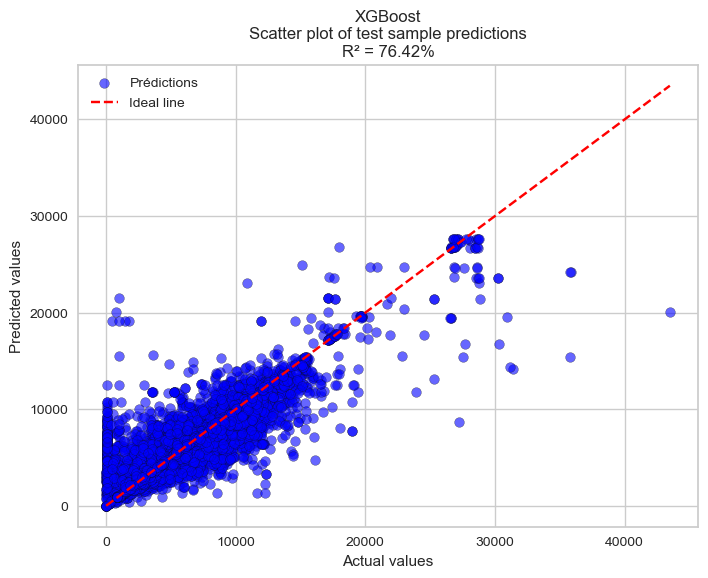

In [ ]:
r2_knn = np.mean(r2_scores_test)
y_test_pred_knn = neigh.predict(X_test_std)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_knn, alpha=0.6, color='blue', edgecolors='k', label='Prédictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal line')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title(f"KNN\nScatter plot of test sample predictions\nR² = {r2_knn*100:.2f}%")
plt.legend()
plt.grid(True)
plt.show()

##### XGB BOOST MODEL

In [ ]:
train_mean_squared_relative_error = []
test_mean_squared_relative_error = []
r2_scores_test = []
r2_scores_train = []

kf = KFold(n_splits=5, random_state=42, shuffle=True)
scaler = StandardScaler()
xgb_model = xgb.XGBRegressor(n_estimators=5, random_state=42, max_depth=17)

for train_andex, test_andex in kf.split(X):

    X_train_kf, X_test_kf = X.iloc[train_andex], X.iloc[test_andex]
    y_train_kf, y_test_kf = y.iloc[train_andex], y.iloc[test_andex]

    scaler.fit(X_train_kf)
    scaler.fit(X_test_kf)
    X_train_kf_std = scaler.transform(X_train_kf)
    X_test_kf_std = scaler.transform(X_test_kf)

    xgb_model.fit(X_train_kf_std, y_train_kf)
    y_test_pred = xgb_model.predict(X_test_kf_std)
    y_train_pred = xgb_model.predict(X_train_kf_std)


    rse_train = 1- r2_score(y_train_kf, y_train_pred)
    rse_test = 1- r2_score(y_test_kf, y_test_pred)
    r2_test =  r2_score(y_test_kf, y_test_pred)
    r2_train = r2_score(y_train_kf, y_train_pred)


    train_mean_squared_relative_error.append(rse_train)
    test_mean_squared_relative_error.append(rse_test)
    r2_scores_test.append(r2_test)
    r2_scores_train.append(r2_train)

In [ ]:
print("########## relative squared error ############### :")
print(f"mean_squared_relative_error test :  {np.mean(test_mean_squared_relative_error):.2f}")
print(f"mean_squared_relative_error train : {np.mean(train_mean_squared_relative_error):.2f}")
print("########## SCORE ############### :")
print(f"score test :  {np.mean(r2_scores_test):.2f}")
print(f"score train : {np.mean(r2_scores_train):.2f}")

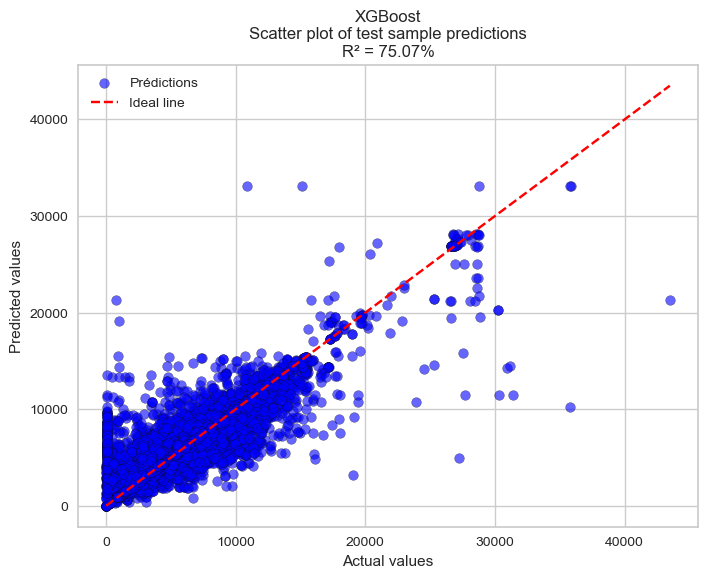

In [ ]:
r2_xgb = np.mean(r2_scores_test)
y_test_pred_xgb = neigh.predict(X_test_std)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_xgb, alpha=0.6, color='blue', edgecolors='k', label='Prédictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal line')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title(f"XGBoost\nScatter plot of test sample predictions\nR² = {r2_xgb*100:.2f}%")
plt.legend()
plt.grid(True)
plt.show()

# Pipepline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin